# Merging the four batches datasets
Group 4: Damiano Chini, Riccardo Gilmozzi, Gianmarco Piccinno & Alessandro Rizzuto Useful links: https://github.com/ComplexityBiosystems/obesity-score https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE2508

In [71]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from scipy.stats import ks_2samp


import copy

In [2]:
def normalize_df(df):
    x= pow(2., df)
    x = x.div(x.sum(axis=1), axis=0)
    return np.log2(x)

In [8]:
batcheslist = ['batch1', 'batch2', 'batch3', 'batch4']
dfs = {}
for batch in batcheslist:
    dfs[batch] = (normalize_df(pd.read_pickle('./output/'+batch+'_exprs.p')))
geno = pd.concat(dfs)
geno.index = geno.index.droplevel(0)
print(geno.head())
print(geno.shape)

                   1         10        100       1000      10000  100009613  \
Lean F 01 -14.498237 -17.394503 -15.567706 -16.788951 -17.188502 -16.171784   
Lean F 02 -15.087327 -19.095387 -15.657845 -17.018402 -16.424505 -16.328808   
Lean F 03 -15.774552 -18.639743 -15.485248 -17.646776 -16.124607 -16.234826   
Lean F 04 -14.826623 -18.566498 -15.885121 -16.293205 -16.369392 -15.001974   
Lean F 05 -14.513295 -18.606968 -15.967244 -16.801863 -16.556843 -16.275280   

           100009676      10001      10002      10003 ...        9988  \
Lean F 01 -16.031785 -15.489873 -15.515150 -17.292039 ...  -17.066215   
Lean F 02 -16.346427 -15.404119 -15.984402 -18.298569 ...  -16.611700   
Lean F 03 -16.138274 -15.735407 -15.480233 -17.676421 ...  -16.933574   
Lean F 04 -16.771676 -15.517890 -16.001900 -16.279368 ...  -17.496063   
Lean F 05 -17.231486 -15.857693 -15.137713 -16.643073 ...  -16.722969   

                9989        999       9990       9991       9992       9993  \
Lean F 

In [40]:
dfs = {}
for batch in batcheslist:
    tmp = pd.read_pickle("./output/"+batch+"_pheno.p")
    tmp["batch"] = batch
    dfs[batch] = (tmp)
pheno = pd.concat(dfs)
pheno.index = pheno.index.droplevel(0)
print(pheno)

             batch   bmi        cbmi fasting_status gender insulin_status
samples                                                                  
Lean F 01   batch1   NaN        lean            NaN      F            NaN
Lean F 02   batch1   NaN        lean            NaN      F            NaN
Lean F 03   batch1   NaN        lean            NaN      F            NaN
Lean F 04   batch1   NaN        lean            NaN      F            NaN
Lean F 05   batch1   NaN        lean            NaN      F            NaN
Lean F 06   batch1   NaN        lean            NaN      F            NaN
Lean F 07   batch1   NaN        lean            NaN      F            NaN
Lean F 08   batch1   NaN        lean            NaN      F            NaN
Lean F 09   batch1   NaN        lean            NaN      F            NaN
Lean F 10   batch1   NaN        lean            NaN      F            NaN
Lean M 01   batch1   NaN        lean            NaN      M            NaN
Lean M 02   batch1   NaN        lean  

In [37]:
geno.drop(geno.columns[geno.isnull().sum()!=0],axis=1,inplace=True)

In [42]:
print("batch  lean   overw   obese   total")
print("---")
for batch in batcheslist:
    l = ((pheno["batch"]==batch) & (pheno["cbmi"]=="lean")).sum()
    over = ((pheno["batch"]==batch) & (pheno["cbmi"]=="overweight")).sum()
    o = ((pheno["batch"]==batch) & (pheno["cbmi"]=="obese")).sum()
    print("%s \t%d \t%d \t%d \t%d" % (batch,l,over,o,l+over+o))
l = (pheno["cbmi"]=="lean").sum()
over = ((pheno["cbmi"]=="overweight")).sum()
o = ((pheno["cbmi"]=="obese")).sum()
print("---")
print("%s%d\t%d\t%d\t%d" % ("ALL\t",l,over,o,l+over+o))

batch  lean   overw   obese   total
---
batch1 	20 	0 	19 	39
batch2 	10 	0 	10 	20
batch3 	6 	10 	17 	33
batch4 	3 	0 	3 	6
---
ALL	39	10	49	98


In [44]:
idx = pheno[(pheno["cbmi"]=="overweight")].index

geno.drop(idx,axis=0,inplace=True)
pheno.drop(idx, axis=0, inplace=True)

In [46]:
print("genes", geno.shape[1])
print("samples (lean):", geno.loc[pheno.cbmi=="lean"].shape[0])
print("samples (obese):", geno.loc[pheno.cbmi=="obese"].shape[0])

genes 15451
samples (lean): 39
samples (obese): 49


In [49]:
ogeno = copy.deepcopy(geno)

In [102]:
with open("./output/batchTot_geno.txt", "w") as handle:
    geno.T.to_csv(handle, sep='\t')
with open("./output/batchTot_pheno.txt", "w") as handle:
    pheno.to_csv(handle, sep='\t') 

# First SVD filtering

In [64]:
def find_level(df,pheno,n=10):
    """
    returns 1./pvalue of distro of n first components being from different distros when split by cbmi
    args:
    df = dataframe with expression values
    pheno = dataframe with labels and metadata
    n = max numb of components
    """
    # make sure we have enough dimensions
    n=min(n,df.shape[0])
    
    res = []
    pca = PCA()
    trans = pca.fit_transform(df)
    df_trans = pd.DataFrame(data = trans[:,:n],index = df.index)
        
    for i in range(n):
        res.append([i,1/ks_2samp(df_trans.loc[(pheno.cbmi=="lean") | (pheno.cbmi=="overweight")].iloc[:,i], df_trans.loc[pheno.cbmi=="obese"].iloc[:,i]).pvalue])
    return np.array(res).T

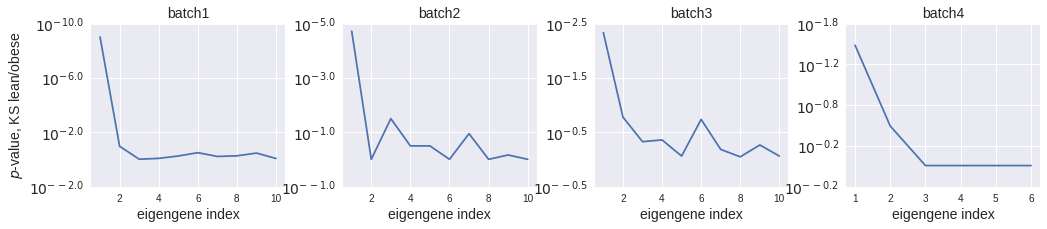

In [79]:
plt.figure(figsize=(17,3))
for i,batch in enumerate(batcheslist):
    plt.subplot(1,4,i+1)
    plt.title(batch,size=14)
    plt.xlabel("eigengene index",size=14)
    if i==0: plt.ylabel("$p$-value, KS lean/obese",size=14)
    y = np.log10(find_level(geno.loc[pheno.batch==batch],pheno)[1])
    plt.plot(range(1,y.shape[0]+1),y)
    yticks = plt.yticks()[0][::2]
    plt.yticks(yticks,["$10^{-%1.1f}$"%i for i in yticks],fontsize=14)
    plt.subplots_adjust(wspace=0.3)

In [83]:
pca = PCA()

for batch in batcheslist:
    effect_strength = find_level(geno.loc[pheno.batch==batch],pheno)[1]
    while np.argmax(effect_strength)!=0:
        tmp = pca.fit_transform(geno.loc[pheno.batch==batch])
        tmp[:,0]=0
        print("One principal component was set to zero on batch", batch)
        geno.loc[pheno.batch==batch] = pca.inverse_transform(tmp)
        effect_strength = find_level(geno.loc[pheno.batch==batch],pheno,n=min(10,geno.loc[pheno.batch==batch].shape[0]))[1]

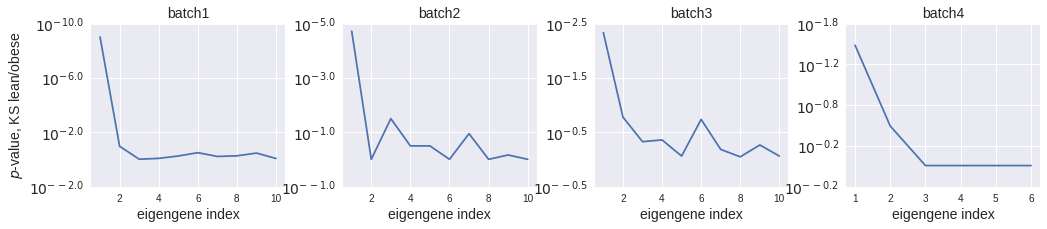

In [85]:


plt.figure(figsize=(17,3))
for i,batch in enumerate(batcheslist):
    plt.subplot(1,4,i+1)
    plt.title(batch,size=14)
    plt.xlabel("eigengene index",size=14)
    if i==0: plt.ylabel("$p$-value, KS lean/obese",size=14)
    y = np.log10(find_level(geno.loc[pheno.batch==batch],pheno)[1])
    plt.plot(range(1,y.shape[0]+1),y)
    yticks = plt.yticks()[0][::2]
    plt.yticks(yticks,["$10^{-%1.1f}$"%i for i in yticks],fontsize=14)
    plt.subplots_adjust(wspace=0.3)



# Second SVD filtering

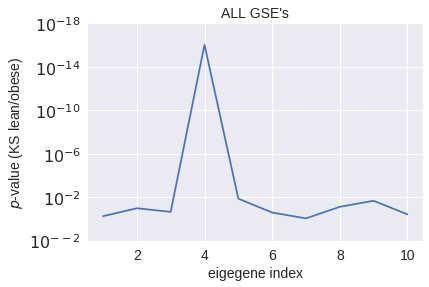

Picking eigengene number 4


In [87]:
plt.title("ALL GSE's",size=14)
plt.plot(range(1,11),np.log10(find_level(geno,pheno)[1]))
plt.xlabel("eigegene index",size=14)
plt.ylabel("$p$-value (KS lean/obese)",size=14)
plt.xticks(fontsize=14)
yticks = plt.yticks()[0][::2]
plt.yticks(yticks,["$10^{-%d}$"%i for i in yticks],fontsize=16)
plt.show()
eigvect_k = np.argmax(find_level(geno,pheno)[1])
print("Picking eigengene number",eigvect_k+1)

In [88]:
pca = PCA()
trans = pca.fit_transform(geno)
trans[:,:eigvect_k]=0
n_geno = pd.DataFrame(index = geno.index,columns=geno.columns,data=pca.inverse_transform(trans))

# Correlation Heatmaps before and after SVD-filtering

In [89]:
K=7

pca_geno = pd.DataFrame(
    data = PCA(n_components=K,whiten=True).fit_transform(geno),
    index = geno.index).T.corr()

pca_ogeno = pd.DataFrame(
    data = PCA(n_components=K,whiten=True).fit_transform(ogeno),
    index = ogeno.index).T.corr()

pca_ngeno = pd.DataFrame(
    data = PCA(n_components=K,whiten=True).fit_transform(n_geno),
    index = ogeno.index).T.corr()



In [90]:
matrix_colors_dict = dict(zip(np.unique(pheno.batch),
                              np.array([sns.palettes.light_palette(x)[2] for x in sns.color_palette(n_colors=7)])[[3,4,5,6]]
                             ))
matrix_colors_dict["lean"] = sns.palettes.light_palette("green")[1]
matrix_colors_dict["obese"] = sns.palettes.light_palette("red")[1]

In [91]:
# sort by batch
order = pheno.sort_values(by=["batch","cbmi"][::1]).index
batchcolors_bybatch = [matrix_colors_dict[pheno.loc[x,"batch"]] for x in order]
cbmicolors_bybatch = [matrix_colors_dict[pheno.loc[x,"cbmi"]] for x in order]

# sort by cbmi
order = pheno.sort_values(by=["batch","cbmi"][::-1]).index
batchcolors_bycbmi = [matrix_colors_dict[pheno.loc[x,"batch"]] for x in order]
cbmicolors_bycbmi = [matrix_colors_dict[pheno.loc[x,"cbmi"]] for x in order]

In [92]:
batch_sizes = np.array([39,20,23,6])
cbmi_size = np.array([39,49])

/home/gianmarco/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


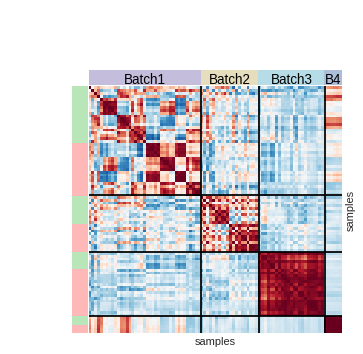

In [94]:
order = pheno.sort_values(by=["batch","cbmi"][::1]).index
big_ax = sns.clustermap(pca_geno.loc[order,order],
               row_cluster=False,col_cluster=False,
               row_colors=cbmicolors_bybatch,
               col_colors=batchcolors_bybatch,
               xticklabels=False,
               yticklabels=False,
               figsize=(6,6)
           )
ax = big_ax.ax_heatmap
big_ax.cax.set_visible(False)
N = n_geno.shape[(0)]
nn=0
for b,n in enumerate(batch_sizes[:-1]):
    nn=nn+n
    ax.axhline(N-nn,color="black")
    ax.axvline(nn,color="black")
    ax.text(nn-n/2,N+1,"Batch"+str(b+1),rotation=0,fontsize=13.5,color="black",horizontalalignment="center")
ax.text(N-3,N+1,"B4",rotation=0,fontsize=13.5,color="black",horizontalalignment="center")
plt.savefig("./output/Figure1a.pdf")
plt.show()

/home/gianmarco/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


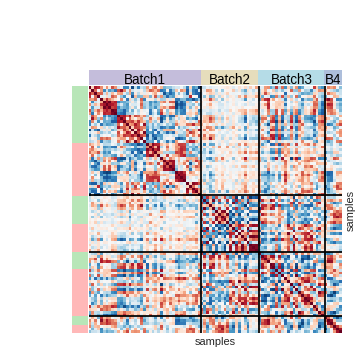

In [96]:


order = pheno.sort_values(by=["batch","cbmi"][::1]).index
big_ax = sns.clustermap(pca_ngeno.loc[order,order],
               row_cluster=False,col_cluster=False,
               row_colors=cbmicolors_bybatch,
               col_colors=batchcolors_bybatch,
               xticklabels=False,
               yticklabels=False,
               figsize=(6,6)
           )
ax = big_ax.ax_heatmap
big_ax.cax.set_visible(False)
N = n_geno.shape[(0)]
nn=0
for b,n in enumerate(batch_sizes[:-1]):
    nn=nn+n
    ax.axhline(N-nn,color="black")
    ax.axvline(nn,color="black")
    ax.text(nn-n/2,N+1,"Batch"+str(b+1),rotation=0,fontsize=13.5,color="black",horizontalalignment="center")
ax.text(N-3,N+1,"B4",rotation=0,fontsize=13.5,color="black",horizontalalignment="center")
plt.savefig("./output/Figure1b.pdf")
plt.show()



/home/gianmarco/anaconda3/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


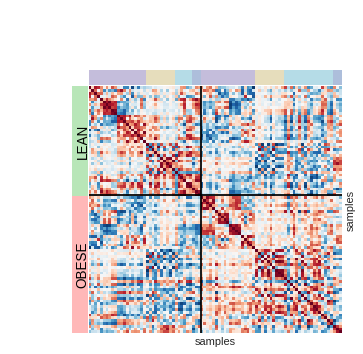

In [97]:


order = pheno.sort_values(by=["batch","cbmi"][::-1]).index
big_ax = sns.clustermap(pca_ngeno.loc[order,order],
               row_cluster=False,col_cluster=False,
               row_colors=cbmicolors_bycbmi,
               col_colors=batchcolors_bycbmi,
               xticklabels=False,
               yticklabels=False,
               figsize=(6,6)
           )
ax = big_ax.ax_heatmap
big_ax.cax.set_visible(False)
N = n_geno.shape[(0)]

ax.axhline(N-39,color="black")
ax.axvline(39,color="black")
ax.text(-4.5,49/2,"OBESE",rotation=90,fontsize=13.5,color="black",verticalalignment="center")
ax.text(-4.5,N-39/2,"LEAN",rotation=90,fontsize=13.5,color="black",verticalalignment="center")
plt.savefig("./output/Figure1c.pdf")
plt.show()



In [101]:
n_geno.to_pickle("./output/batch1234_geno.p")
pheno.to_pickle("./output/batch1234_pheno.p")
with open("./output/batch1234_geno.txt", "w") as handle:
    n_geno.to_csv(handle, sep='\t')
with open("./output/batch1234_pheno.txt", "w") as handle:
    pheno.to_csv(handle, sep='\t')    